In [ ]:
!unzip images.zip -d images

Archive:  images.zip
   creating: images/images/
  inflating: images/images/be6042fe820a549daa9638c9b2bad29b_389021216_39.jpg  
  inflating: images/images/25208a7ff9cabe2bcc7e73b62151f070_104959991_37.jpg  
  inflating: images/images/dc1d6ad7bd8036a7e6d7d99785c6f3ae_264326314_22.jpg  
  inflating: images/images/43fc1cd3e5160af88dfeec2c997d1d0f_287549684_35.jpg  
  inflating: images/images/ba755e852d12abe7916f9f6d8264fc25_318102301_2.jpg  
  inflating: images/images/ab6f104d20e6bcb7e2e15786cc5922ef_435032028_38.jpg  
  inflating: images/images/c9a9c46d010043c6ced0eeecb7503491_201437338_39.jpg  
  inflating: images/images/dc1d6ad7bd8036a7e6d7d99785c6f3ae_266968873_8.jpg  
  inflating: images/images/5f77897d932e9e2becf41ccd5f49b7a9_413562864_39.jpg  
  inflating: images/images/d142d70409d08bf3da7edf466687d7e4_221389093_1.jpg  
  inflating: images/images/0d104d0f1446996a3f88c02ee646b838_217937399_23.jpg  
  inflating: images/images/815ccb7dec8259908d6bef4720579a8f_252819562_43.jpg  
  infl

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models

import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

import time


np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)


In [ ]:
df = pd.read_csv('data.csv')

def proccess_price(raw_price):
    try:
        return int(raw_price.replace('₽', '').replace(' ', ''))
    except:
        return pd.NA

df['price'] = df['price'].apply(proccess_price)
df = df[['price', 'image_path']]
df = df.dropna()
df

,price,image_path
0,4591,images/1b4b13b88e23910429afadb53dd1ecc4_340573...
1,3577,images/8f56c25d2270bcb4f38c43969c700959_405958...
2,12692,images/dd53f9081af7d8189e9f585c4457205f_340573...
3,3892,images/5708c954a1ff9f8fa073b4331e918394_389414...
4,4399,images/074d0ad3dba1d308ab8c1e77a909f7c4_182907...
...,...,...
1350,8095,images/f1c764e366b2ea1b4dc7f76c5f311a4e_264067...
1351,9601,images/aeb800c9309175d4a304f2a2bc0bda0c_272587...
1352,8218,images/dc567b251d7760d5928cca170c97be20_329698...
1353,8971,images/682af07b2e7480956451ff56a6c5bfd3_254552...


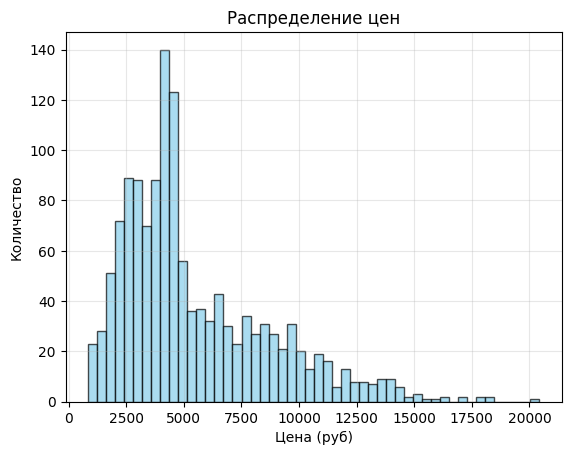

In [ ]:
plt.hist(df['price'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Цена (руб)')
plt.ylabel('Количество')
plt.title('Распределение цен')
plt.grid(True, alpha=0.3)

plt.show()

Распределено с явным смещением влево, но если взять логарифм...

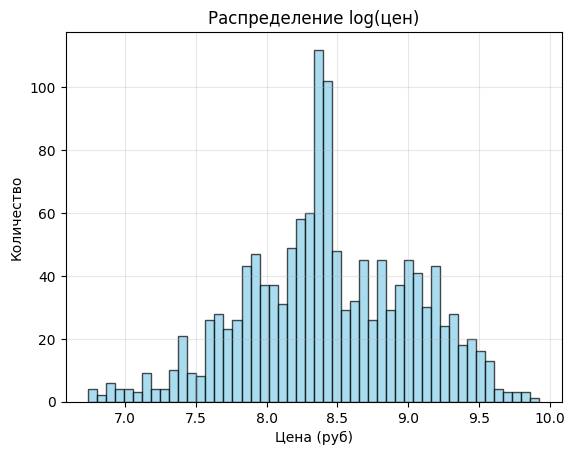

In [ ]:
plt.hist(np.log(df['price'].astype(float)), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Цена (руб)')
plt.ylabel('Количество')
plt.title('Распределение log(цен)')
plt.grid(True, alpha=0.3)

plt.show()

Получим симметричное распределение, довольно нормлальное по форме

если растянем его на диапазон от 0 до 10, получим отличный таргет для предсказания

In [ ]:
a, b = 0.3, 22

In [ ]:
df['target'] = np.log(df['price'].astype(float)) / a - b
df

,price,image_path,target
0,4591,images/1b4b13b88e23910429afadb53dd1ecc4_340573...,6.106177
1,3577,images/8f56c25d2270bcb4f38c43969c700959_405958...,5.274266
2,12692,images/dd53f9081af7d8189e9f585c4457205f_340573...,9.495757
3,3892,images/5708c954a1ff9f8fa073b4331e918394_389414...,5.555595
4,4399,images/074d0ad3dba1d308ab8c1e77a909f7c4_182907...,5.963775
...,...,...,...
1350,8095,images/f1c764e366b2ea1b4dc7f76c5f311a4e_264067...,7.996673
1351,9601,images/aeb800c9309175d4a304f2a2bc0bda0c_272587...,8.565408
1352,8218,images/dc567b251d7760d5928cca170c97be20_329698...,8.046940
1353,8971,images/682af07b2e7480956451ff56a6c5bfd3_254552...,8.339175


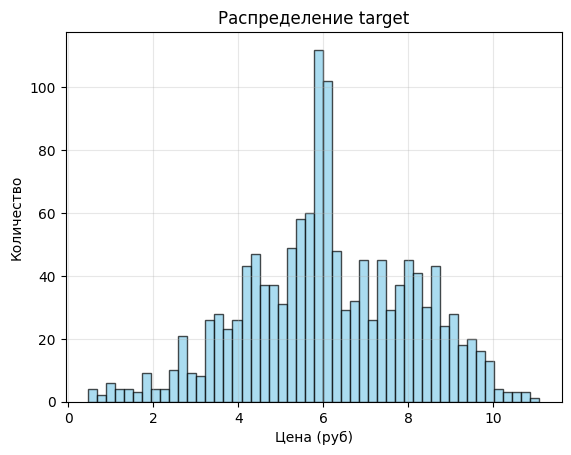

In [ ]:
plt.hist(df['target'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Цена (руб)')
plt.ylabel('Количество')
plt.title('Распределение target')
plt.grid(True, alpha=0.3)

plt.show()

Теперь посмотрим оценки для нескольких примеров, чтобы оценить, насколько вообще имеет смысл такая метрика

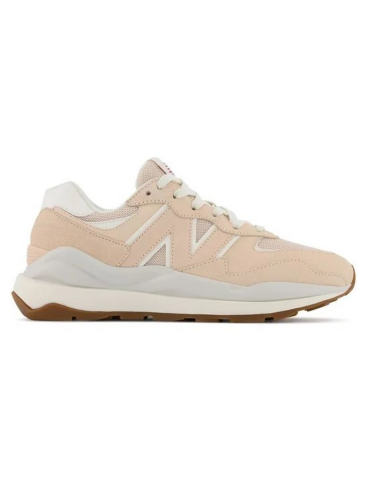

Expected Q: 9.81


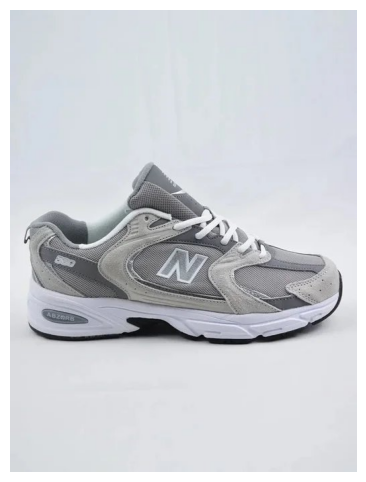

Expected Q: 5.15


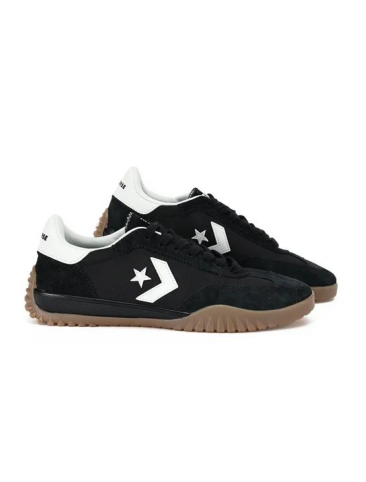

Expected Q: 5.49


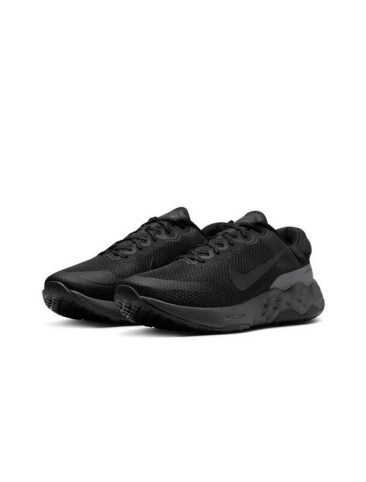

Expected Q: 7.75


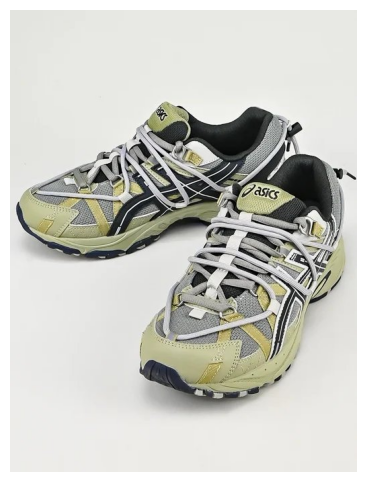

Expected Q: 5.84


In [ ]:
for _ in range(5):
    row = df.sample(1)
    target, img_path = row['target'].item(), row['image_path'].item()
    test_image = Image.open('images/' + img_path).convert('RGB')
    plt.figure(figsize=(8, 6))
    plt.imshow(test_image)
    plt.axis('off')
    plt.show()
    print(f'Expected Q: {round(target, 2)}')
    time.sleep(3)

Возможны дискуссии, но в целом выглядит хорошо. Будем учиться предсказывать

In [ ]:
class PriceImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = 'images/' + row['image_path']
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        target = torch.tensor(row['target'], dtype=torch.float32)

        return image, target


Данных у нас достаточно мало, так что обязательно применяем аугментацию

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


Использую батч размера 64: выборка небольшая, 1000 объектов, но хочется перебирвать не по одному

In [ ]:
def prepare_data(df, test_size=0.2):
    train_df, val_df = train_test_split(
        df,
        test_size=test_size
    )

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset = PriceImageDataset(train_df, transform=transform_train)
    val_dataset = PriceImageDataset(val_df, transform=transform_val)

    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=2
    )

    return train_loader, val_loader


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, prices in tqdm(dataloader, desc='Training'):
        images = images.to(device)
        prices = prices.to(device).unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, prices)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for images, prices in tqdm(dataloader, desc='Validation'):
            images = images.to(device)
            prices = prices.to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, prices)

            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(prices.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    return total_loss / len(dataloader), mape


Будем использовать MSELoss

Также в качестве базового решения возьмем оптимизатор Adam; начальный lr возьмем 1е-4 и каждые 5 эпох будем домножать на 0.7

In [ ]:
def train_model(df, Model, num_epochs, criterion=nn.MSELoss(), lr=1e-4):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    train_loader, val_loader = prepare_data(df)

    model = Model()
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size=5,
        gamma=0.7
    )

    train_losses = []
    val_losses = []
    val_mapes = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

        val_loss, val_mape = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_mapes.append(val_mape)

        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Val MAPE: {val_mape:.2f}%')

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'weights/' + Model.__name__ + f'_{round(val_mape * 100)}.pth')
            print('Model saved!')

    return model, train_losses, val_losses, val_mapes


Попробуем 3 различных архитектуры:

1) Предобученная сеть resnet50 с новыми полносвязными слоями в конце

2) Сверточная сеть, полностью своя. 5 сверток, затем полносвязная сеть в конце

3) Просто полносвязная сеть. Интересно, как справится

In [ ]:
class MetaModel():

    def __init__(self, ModelType):
        self.model_type = ModelType
        self.model = ModelType()

    def fit(self, df):
        self.model, _, _, val_mapes = train_model(df, self.model_type, num_epochs=20)
        return val_mapes[-1]

    def predict(self, image_path):
        self.model.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        image = Image.open(image_path).convert('RGB')
        image = transform_val(image).unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = self.model(image)

        return prediction.item()

    def pretty_predict(self, image_path):
        predict = self.predict(image_path)
        return str(round(predict, 1)) + ' / 10'

    def load(self, path):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.load_state_dict(torch.load(path))
        self.model = self.model.to(device)
        self.model.eval()


class CNNRegressorPretrained(nn.Module):
    def __init__(self):
        super(CNNRegressorPretrained, self).__init__()

        self.backbone = models.resnet50(weights='DEFAULT')

        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.backbone(x)


class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.regressor = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)
        return x


class FCNRegressor(nn.Module):
    def __init__(self):
        super(FCNRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


In [ ]:
def plot_results(train_losses, val_losses, val_mapes):
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(val_mapes, label='Val MAPE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAPE (%)')
    ax2.set_title('Validation MAPE')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


def show_image(test_image_path):
    test_image = Image.open(test_image_path).convert('RGB')
    plt.figure(figsize=(8, 6))
    plt.imshow(test_image)
    plt.axis('off')



Using device: cuda

Epoch 1/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Train Loss: 34.3506
Val Loss: 14.9191
Val MAPE: 54.24%
Model saved!

Epoch 2/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Train Loss: 8.8652
Val Loss: 5.8467
Val MAPE: 44.40%
Model saved!

Epoch 3/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Train Loss: 3.0976
Val Loss: 3.5940
Val MAPE: 26.90%
Model saved!

Epoch 4/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Train Loss: 1.9107
Val Loss: 2.7853
Val MAPE: 24.42%
Model saved!

Epoch 5/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Train Loss: 1.4170
Val Loss: 2.1362
Val MAPE: 22.87%
Model saved!

Epoch 6/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Train Loss: 1.2102
Val Loss: 2.3498
Val MAPE: 23.47%

Epoch 7/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Train Loss: 1.1691
Val Loss: 2.1243
Val MAPE: 22.56%
Model saved!

Epoch 8/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Train Loss: 1.0458
Val Loss: 1.9463
Val MAPE: 21.40%
Model saved!

Epoch 9/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Train Loss: 1.0095
Val Loss: 1.7219
Val MAPE: 20.56%
Model saved!

Epoch 10/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Train Loss: 0.8297
Val Loss: 1.8188
Val MAPE: 21.68%

Epoch 11/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


Train Loss: 0.8068
Val Loss: 1.8760
Val MAPE: 20.47%

Epoch 12/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Train Loss: 0.7303
Val Loss: 1.7538
Val MAPE: 20.86%

Epoch 13/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Train Loss: 0.6762
Val Loss: 1.7043
Val MAPE: 20.41%
Model saved!

Epoch 14/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Train Loss: 0.6783
Val Loss: 1.8016
Val MAPE: 20.52%

Epoch 15/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Train Loss: 0.6321
Val Loss: 1.8473
Val MAPE: 20.73%

Epoch 16/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Train Loss: 0.6577
Val Loss: 1.7063
Val MAPE: 19.70%

Epoch 17/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Train Loss: 0.6128
Val Loss: 1.8439
Val MAPE: 20.68%

Epoch 18/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Train Loss: 0.6257
Val Loss: 2.0126
Val MAPE: 20.38%

Epoch 19/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Train Loss: 0.5148
Val Loss: 1.8798
Val MAPE: 20.67%

Epoch 20/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Train Loss: 0.5984
Val Loss: 1.8923
Val MAPE: 20.32%


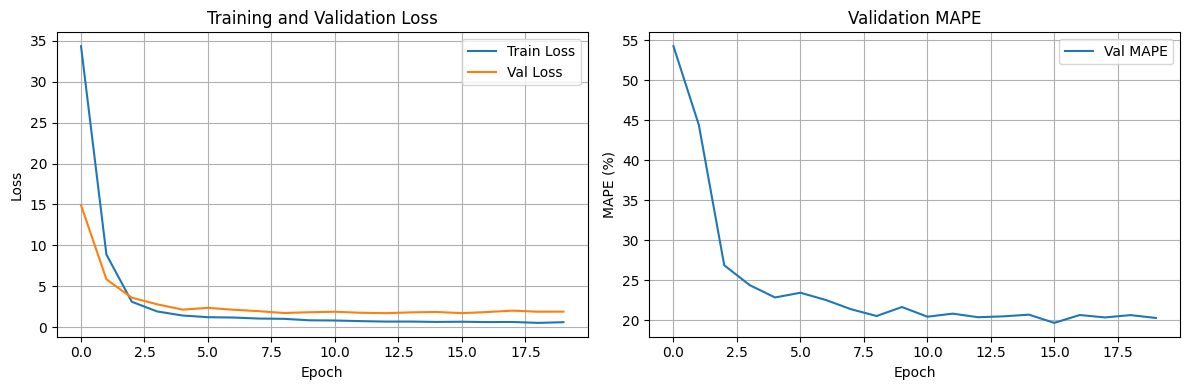

In [ ]:
_, train_losses, val_losses, val_mapes = train_model(df, CNNRegressorPretrained, num_epochs=20)
plot_results(train_losses, val_losses, val_mapes)

In [ ]:
_, train_losses, val_losses, val_mapes = train_model(df, CNNRegressor, num_epochs=20)
plot_results(train_losses, val_losses, val_mapes)

In [ ]:
_, train_losses, val_losses, val_mapes = train_model(df, FCNRegressor, num_epochs=20)
plot_results(train_losses, val_losses, val_mapes)

Лучше всех справляется CNNRegressorPretrained

Давайте возьмем картинки, которые он еще не видел (с другого маркетплейса), и оценим качество

In [ ]:
model = MetaModel(CNNRegressorPretrained)
model.load('/content/weights/CNNRegressorPretrained_2041.pth')

'4.2 / 10'

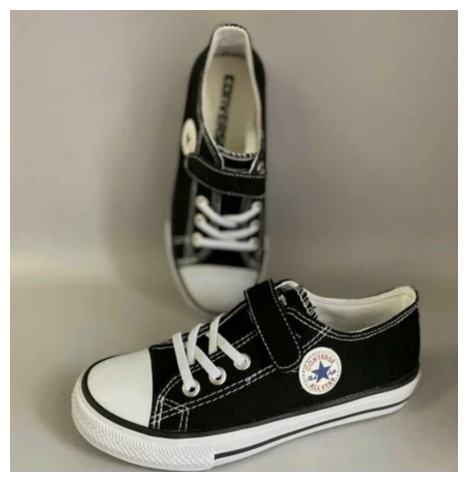

In [ ]:
image = 'converse_bad.png'

show_image(image)
model.pretty_predict(image)

'6.8 / 10'

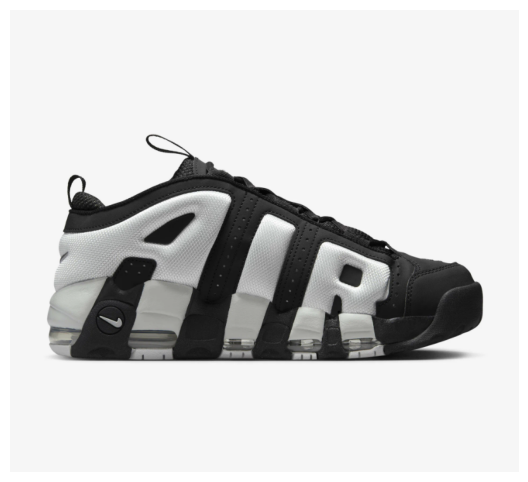

In [ ]:
image = 'nike_good.png'

show_image(image)
model.pretty_predict(image)

'4.0 / 10'

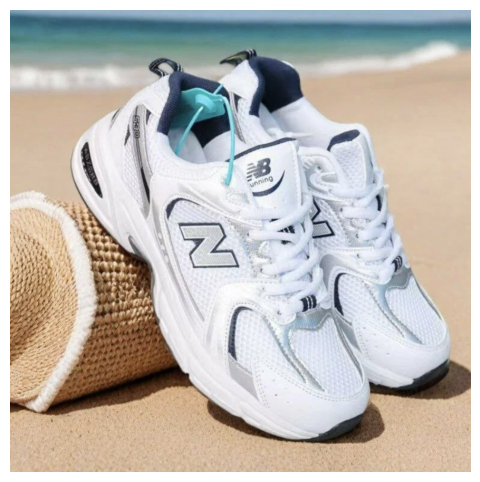

In [ ]:
image = 'nb_bad.png'

show_image(image)
model.pretty_predict(image)

'5.7 / 10'

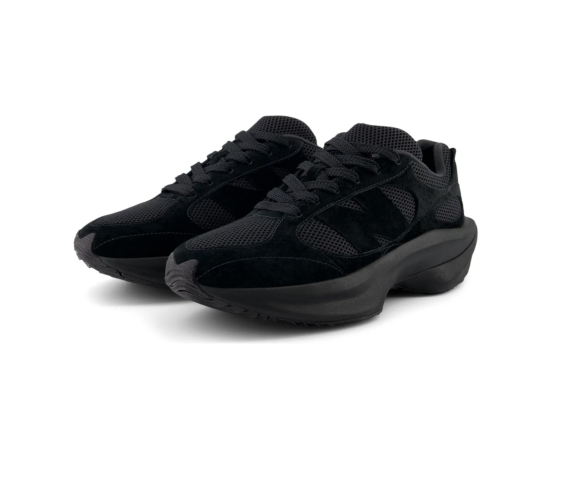

In [ ]:
image = 'nb_ultima.png'

show_image(image)
model.pretty_predict(image)

Все ничего, размышления действительно в нужную сторону

Попробуем для интереса что-нибудь перебрать. Например, optimizer

Будем выбирать из optim.Adam, optim.AdamW, optim.SGD с дефолтными значениями

In [ ]:
def train_model_v2(df, Model, num_epochs, criterion=nn.MSELoss()):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    train_loader, val_loader = prepare_data(df)

    for optimizer_type in [optim.Adam, optim.AdamW, optim.SGD]:

        print(optimizer_type)

        model = Model()
        model = model.to(device)

        optimizer = optimizer_type(model.parameters(), lr=0.0001)

        scheduler = optim.lr_scheduler.StepLR(
            optimizer,
            step_size=5,
            gamma=0.7
        )

        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')

            train_epoch(model, train_loader, criterion, optimizer, device)

            scheduler.step()

        val_loss, val_mape = validate_epoch(model, val_loader, criterion, device)

        print(val_loss, val_mape)


In [ ]:
train_model_v2(df, CNNRegressorPretrained, 20)

Using device: cuda
<class 'torch.optim.adam.Adam'>

Epoch 1/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]



Epoch 2/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]



Epoch 3/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]



Epoch 4/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]



Epoch 5/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]



Epoch 6/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]



Epoch 7/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]



Epoch 8/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]



Epoch 9/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]



Epoch 10/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]



Epoch 11/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]



Epoch 12/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]



Epoch 13/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]



Epoch 14/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]



Epoch 15/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]



Epoch 16/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]



Epoch 17/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]



Epoch 18/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]



Epoch 19/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]



Epoch 20/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


2.033128023147583 19.829031
<class 'torch.optim.adamw.AdamW'>

Epoch 1/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]



Epoch 2/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]



Epoch 3/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]



Epoch 4/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]



Epoch 5/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]



Epoch 6/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]



Epoch 7/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]



Epoch 8/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]



Epoch 9/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]



Epoch 10/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]



Epoch 11/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]



Epoch 12/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]



Epoch 13/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]



Epoch 14/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]



Epoch 15/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]



Epoch 16/20


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]



Epoch 17/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]



Epoch 18/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]



Epoch 19/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]



Epoch 20/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


2.0435321807861326 20.50352
<class 'torch.optim.sgd.SGD'>

Epoch 1/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]



Epoch 2/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]



Epoch 3/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]



Epoch 4/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]



Epoch 5/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]



Epoch 6/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]



Epoch 7/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]



Epoch 8/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]



Epoch 9/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]



Epoch 10/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]



Epoch 11/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]



Epoch 12/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]



Epoch 13/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]



Epoch 14/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]



Epoch 15/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]



Epoch 16/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]



Epoch 17/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]



Epoch 18/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]



Epoch 19/20


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]



Epoch 20/20


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

32.838958740234375 89.77046


Adam справляется на копеечку лучше AdamW!

Еще хочется посмотреть, а где же ошибается модель

In [ ]:
results = []

for i in tqdm(range(1350)):
    target, img = df.iloc[i]['target'], 'images/' + df.iloc[i]['image_path']
    predict = model.predict(img)
    results.append([abs(predict - target), img, i])

100%|██████████| 1350/1350 [00:19<00:00, 70.42it/s]


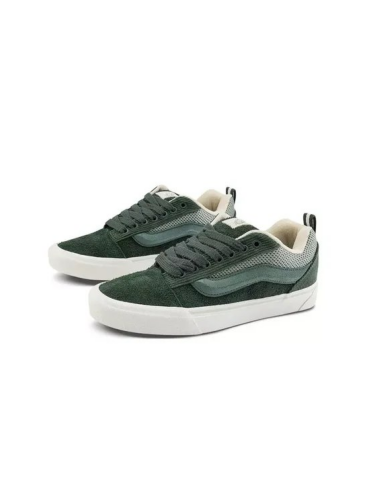

Predicted: 3.32
Actual: 8.098059453653121


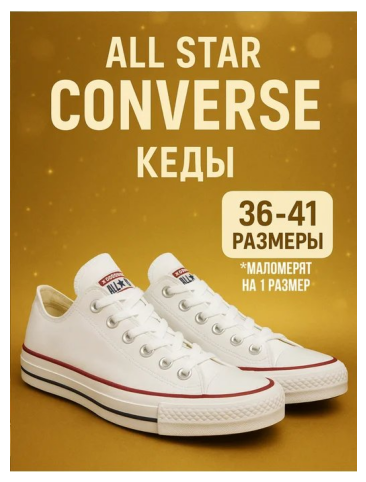

Predicted: 5.69
Actual: 1.5803893873245407


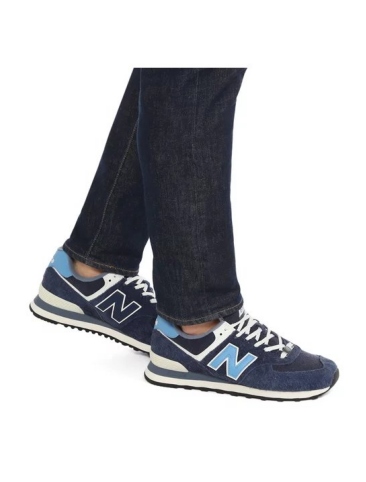

Predicted: 6.14
Actual: 9.931393608773195


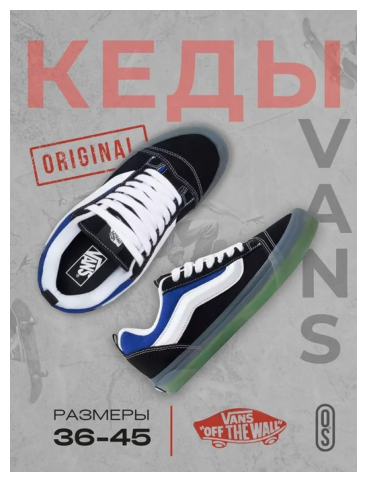

Predicted: 4.95
Actual: 8.391889906079431


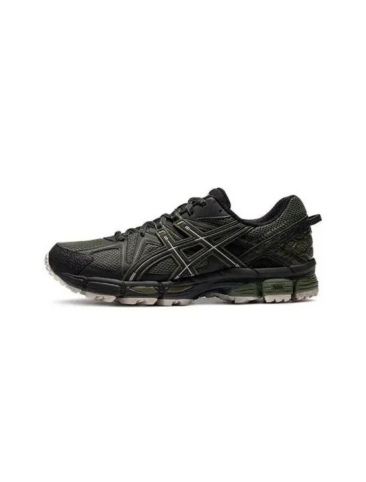

Predicted: 6.76
Actual: 3.3363415318069407


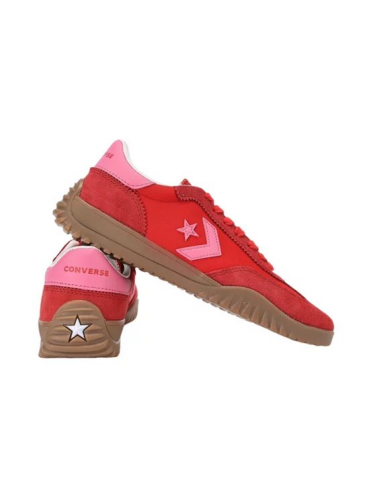

Predicted: 7.31
Actual: 4.010088812107391


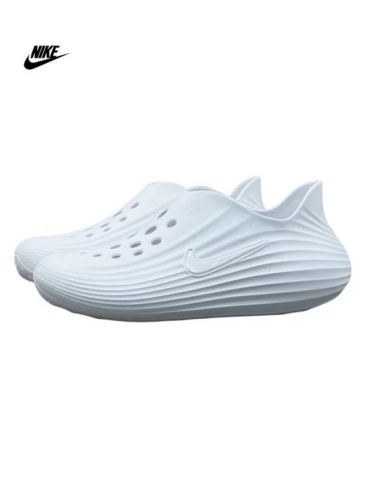

Predicted: 7.77
Actual: 4.537900672398372


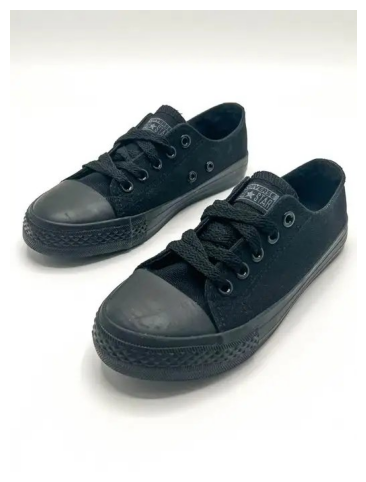

Predicted: 4.25
Actual: 1.0689050141622793


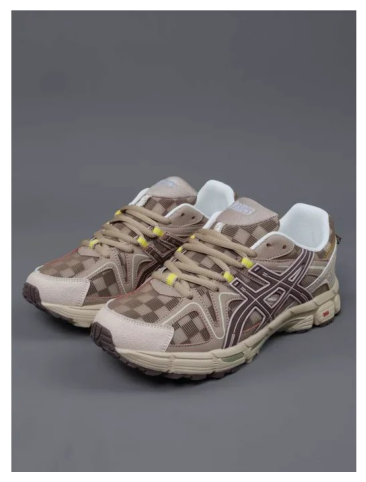

Predicted: 6.75
Actual: 3.599045466554575


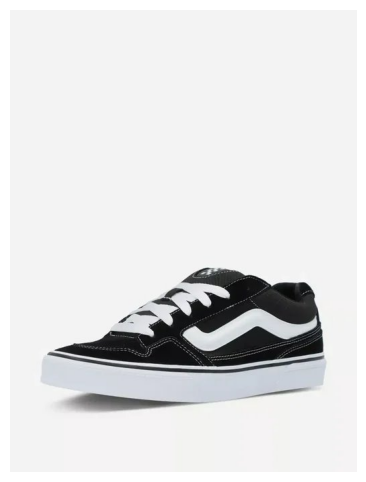

Predicted: 5.2
Actual: 8.098059453653121


In [ ]:
for _, test_image_path, i in sorted(results)[1349:1339:-1]:
    test_image = Image.open(test_image_path).convert('RGB')
    plt.figure(figsize=(8, 6))
    plt.imshow(test_image)
    plt.axis('off')
    plt.show()

    predict = model.predict(test_image_path)
    print(f'Predicted: {round(predict, 2)}')
    print(f'Actual: {df.iloc[i]["target"]}')
    time.sleep(5)

Среди этих топ-10 присутствуют сомнительные варианты. Обрежем 200 объектов с самыми большими ошибками

In [ ]:
to_delete = [i for _, _, i in sorted(results)[1349:1149:-1]]
df_trimmed = df.reset_index().drop(to_delete).drop('index', axis=1)
df_trimmed

Using device: cuda

Epoch 1/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Train Loss: 36.2840
Val Loss: 32.1743
Val MAPE: 86.83%
Model saved!

Epoch 2/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


Train Loss: 24.9582
Val Loss: 10.3687
Val MAPE: 48.51%
Model saved!

Epoch 3/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


Train Loss: 10.0820
Val Loss: 3.0997
Val MAPE: 26.21%
Model saved!

Epoch 4/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Train Loss: 3.0791
Val Loss: 2.0375
Val MAPE: 21.73%
Model saved!

Epoch 5/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


Train Loss: 2.0492
Val Loss: 2.0149
Val MAPE: 20.91%
Model saved!

Epoch 6/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Train Loss: 1.5658
Val Loss: 2.2609
Val MAPE: 21.79%

Epoch 7/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Train Loss: 1.2655
Val Loss: 1.7662
Val MAPE: 19.53%
Model saved!

Epoch 8/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


Train Loss: 1.1696
Val Loss: 1.7820
Val MAPE: 19.35%

Epoch 9/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Train Loss: 1.0010
Val Loss: 1.8028
Val MAPE: 19.29%

Epoch 10/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


Train Loss: 1.0147
Val Loss: 1.7206
Val MAPE: 19.17%
Model saved!

Epoch 11/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


Train Loss: 0.9164
Val Loss: 1.5792
Val MAPE: 18.50%
Model saved!

Epoch 12/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Train Loss: 0.8880
Val Loss: 1.5724
Val MAPE: 18.34%
Model saved!

Epoch 13/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


Train Loss: 0.8027
Val Loss: 1.4673
Val MAPE: 17.72%
Model saved!

Epoch 14/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


Train Loss: 0.7217
Val Loss: 1.5004
Val MAPE: 17.71%

Epoch 15/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Train Loss: 0.7691
Val Loss: 1.5144
Val MAPE: 17.74%

Epoch 16/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Train Loss: 0.6901
Val Loss: 1.3681
Val MAPE: 17.22%
Model saved!

Epoch 17/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Train Loss: 0.7022
Val Loss: 1.4988
Val MAPE: 17.68%

Epoch 18/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


Train Loss: 0.7236
Val Loss: 1.4037
Val MAPE: 17.20%

Epoch 19/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Train Loss: 0.5938
Val Loss: 1.4721
Val MAPE: 17.65%

Epoch 20/20


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


Train Loss: 0.6803
Val Loss: 1.3618
Val MAPE: 17.14%
Model saved!


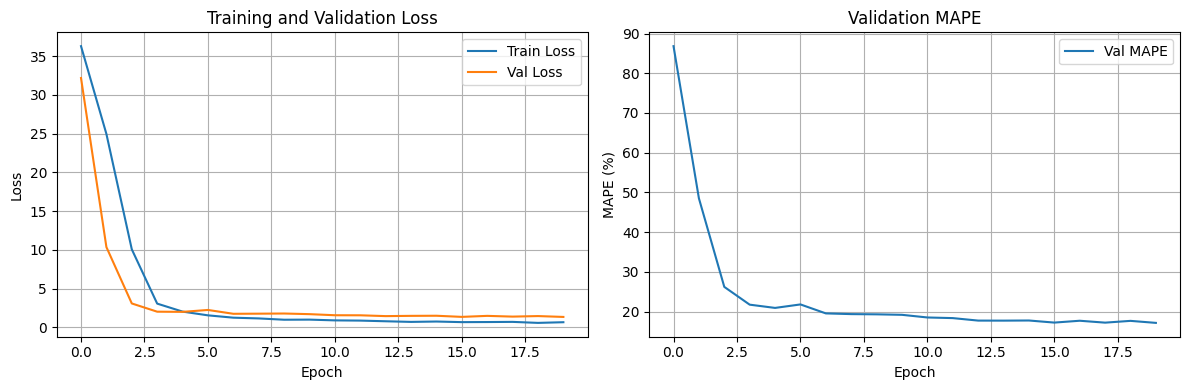

In [ ]:
_, train_losses, val_losses, val_mapes = train_model(df_trimmed, CNNRegressorPretrained, num_epochs=20, lr=5e-5)
plot_results(train_losses, val_losses, val_mapes)

+3% к качеству! Но так ли это хорошо, либо мы просто убрали плохие примеры? :)

Давайте еще раз что-нибудь посмотрим

In [ ]:
model = MetaModel(CNNRegressorPretrained)
model.load('/content/weights/CNNRegressorPretrained_1714.pth')

'5.6 / 10'

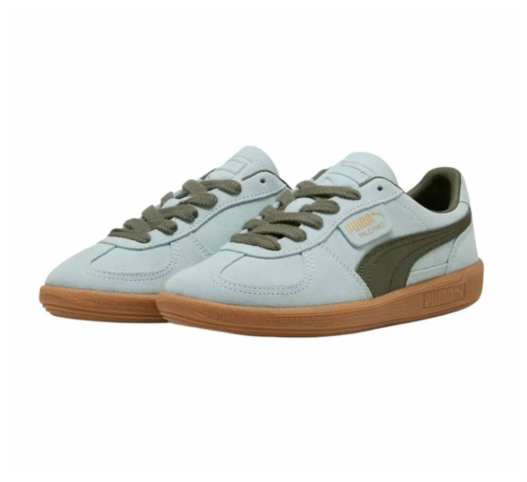

In [ ]:
image = 'puma_good.png'

show_image(image)
model.pretty_predict(image)

'6.2 / 10'

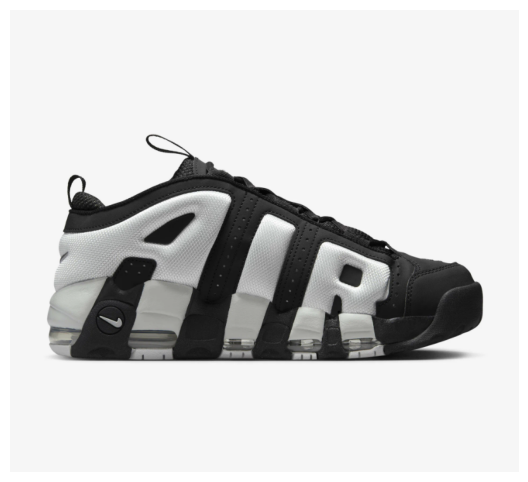

In [ ]:
image = 'nike_good.png'

show_image(image)
model.pretty_predict(image)

'3.0 / 10'

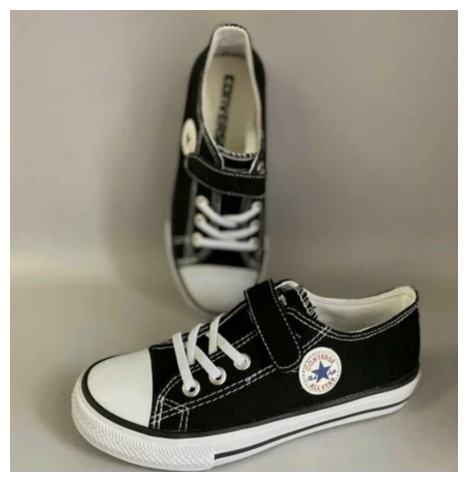

In [ ]:
image = 'converse_bad.png'

show_image(image)
model.pretty_predict(image)

Трудно сказать, что стало заметно лучше - да и разница всего 3% на очищенных данных

В целом оценки отражают действительность